In [6]:
import os
from IPython.display import Image
os.sys.path.insert(0, '../../../')
SRC_DOCS = os.path.realpath(os.path.join(os.getcwd(), '..', '..', '..', 'src_docs', '_static' ))

# Example Mesh

This is the example mesh that we will be using in our discussion

In [42]:
import open3d as o3d
import numpy as np
import time
from fastga.o3d_util import plot_meshes, assign_vertex_colors, create_open_3d_mesh, get_colors, get_arrow_normals
from examples.python.util.mesh_util import BASEMENT_CHAIR


mesh = o3d.io.read_triangle_mesh(str(BASEMENT_CHAIR))
mesh = mesh.compute_triangle_normals()
plot_meshes([mesh], axis_translate=[-1.00, 0, 1])

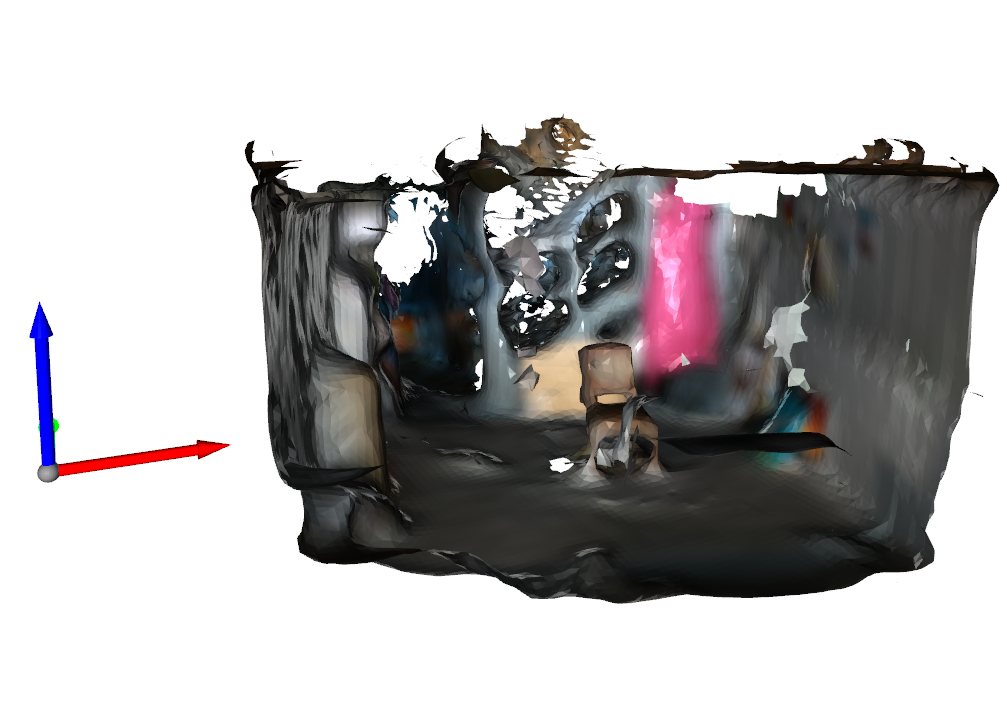

In [7]:
Image(f"{SRC_DOCS}/tutorials/example_mesh.png")

# Creating Histogram

This section will teach you first how to create the Gaussian Accumulator and then integrate triangle normals into its spherical histogram.

We imported the class and then created the accumulator. The `level=3` indicates a third level of refinement of approximating a sphere. The higher the levels the more smooth-like sphere surface we get. I would stick to 3 or 4.

In [9]:
from fastga import GaussianAccumulatorS2
ga_cpp_s2 = GaussianAccumulatorS2(level=3)
ga_cpp_s2

<FastGA::GAS2; # Triangles: '1280'>

Next we need to integrate the triangle normals of the mesh into the GA. You generally do NOT need all the triangles, meaning you can randomly down-sample from the mesh. For this example we will just use all of them.

In [29]:
from fastga import MatX3d

num_triangles = np.asarray(mesh.triangle_normals).shape[0]
triangle_normals = MatX3d(np.asarray(mesh.triangle_normals))
t0 = time.perf_counter()
bucket_indices = ga_cpp_s2.integrate(triangle_normals)
t1 = time.perf_counter()

print(f"Integrated {num_triangles:d} triangle normals into the histogram in {(t1-t0) * 1000:.2f} milliseconds")

Integrated 65051 triangle normals into the histogram in 7.63 milliseconds


If you want to visualize this we have some helper functions here. This is totally optional.

In [37]:
# For visualization
normalized_counts = np.asarray(ga_cpp_s2.get_normalized_bucket_counts())
color_counts = get_colors(normalized_counts)[:, :3]
refined_icosahedron_mesh = create_open_3d_mesh(np.asarray(ga_cpp_s2.mesh.triangles), np.asarray(ga_cpp_s2.mesh.vertices))
# Colorize normal buckets
colored_icosahedron = assign_vertex_colors(refined_icosahedron_mesh, color_counts, None)
plot_meshes([colored_icosahedron], axis_translate=[-1.50, 0, 0])

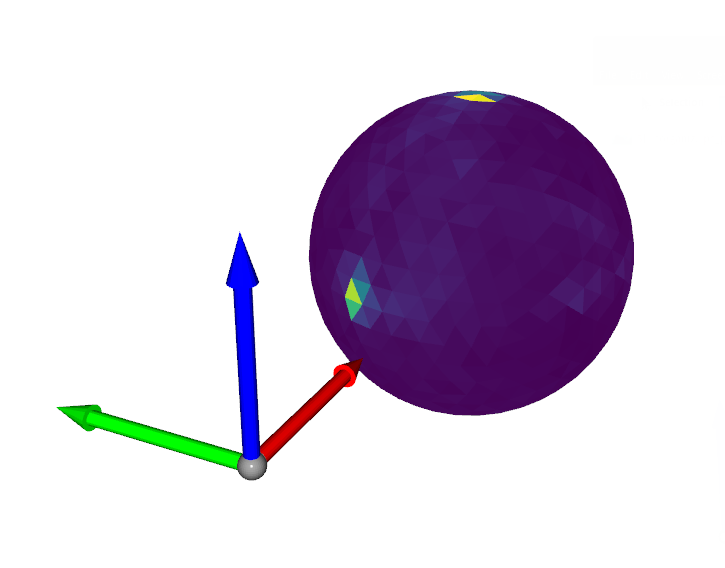

In [38]:
Image(f"{SRC_DOCS}/tutorials/example_ga_color.png")

# Peak Detection

This section will show you how to perform peak detection on the histogram. The basic idea is to unwrap the refined icosahedron into a 2D image and perform peak detection.

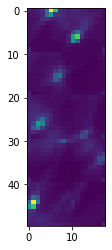

In [45]:
from fastga import IcoCharts
from fastga.peak_and_cluster import find_peaks_from_ico_charts
import matplotlib.pyplot as plt

ico_chart = IcoCharts(level=3) # make sure it has the same level
normalized_bucket_counts_by_vertex = ga_cpp_s2.get_normalized_bucket_counts_by_vertex(True) # must be set to true
ico_chart.fill_image(normalized_bucket_counts_by_vertex)

plt.imshow(np.asarray(ico_chart.image))

Each pixel on the image roughly corresponds to a *vertex* on the icosahedron.  We now perform peak detection. Note that there is some copy padding ghost cells but the function `find_peaks_from_ico_charts` will take care of that. Please see documentation on this function to learn what the parameters do.

In [51]:
# These are your configurable parameters
find_peaks_kwargs = dict(threshold_abs=50, min_distance=1, exclude_border=False, indices=False) # skimage.features.local_max
cluster_kwargs = dict(t=0.2, criterion='distance') # scipy.spatial.fcluster
average_filter = dict(min_total_weight=0.05) # noramlized avergate weight of each group must have this min value

peaks, clusters, avg_peaks, avg_weights = find_peaks_from_ico_charts(ico_chart, np.asarray(
    normalized_bucket_counts_by_vertex), find_peaks_kwargs, cluster_kwargs, average_filter)
gaussian_normals_sorted = np.asarray(ico_chart.sphere_mesh.vertices)
arrow_avg_peaks = get_arrow_normals(avg_peaks, avg_weights)

print(avg_peaks)
plot_meshes([colored_icosahedron, *arrow_avg_peaks], axis_translate=[-1.50, 0, 0])

[[ 0.          0.          1.        ]
 [ 0.90559982 -0.40313874  0.13178818]
 [-0.96193836  0.27326653  0.        ]
 [ 0.          0.         -1.        ]
 [ 0.2664047   0.96386126  0.        ]]


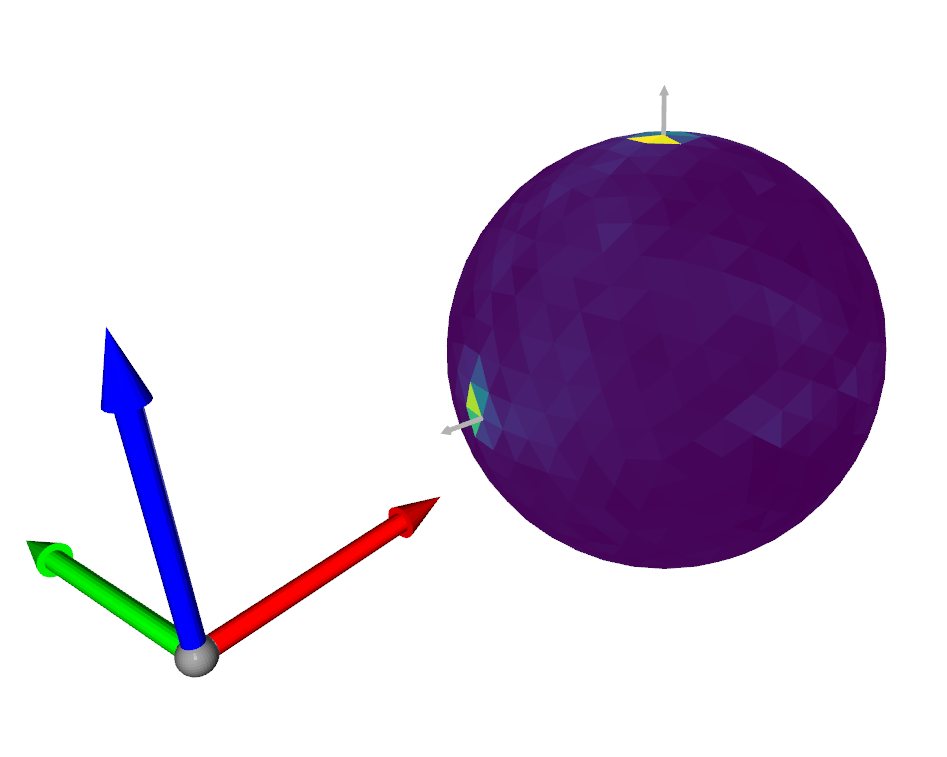

In [50]:
Image(f"{SRC_DOCS}/tutorials/example_ga_peak.png")